<a href="https://colab.research.google.com/github/motechbello1/motechbello1.github.io/blob/main/ASL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from time import perf_counter
import seaborn as sns
import cv2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/data/sign_mnist_train.csv')
test = pd.read_csv('/content/drive/MyDrive/data/sign_mnist_test.csv')

In [ ]:
x_train = train.iloc[:,1:]
y_train = train.iloc[:,0]
x_test = test.iloc[:,1:]
y_test = test.iloc[:,0]

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train= to_categorical(y_train)
y_test= to_categorical(y_test)

In [ ]:
x_train = x_train.values.reshape(-1,28,28,1)

In [ ]:
x_test = x_test.values.reshape(-1,28,28,1)


In [ ]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [ ]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,172,175,185,183,184,185,185,185,183,183,182,181,178,86,88,93,96,108,125,137,145,149,154,160,...,145,123,78,162,239,227,229,226,226,225,224,222,89,91,94,111,136,154,167,184,125,3,166,225,195,188,172,185,161,122,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,209,208,207,207,209,208,210,210,207,209,209,208,209,210,209,207,208,209,207,206,208,209,208,208,210,211,210,211,209,209,...,85,80,84,151,238,255,255,250,237,245,250,232,103,101,102,103,95,208,231,227,209,190,179,182,152,150,159,119,83,63,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,203,202,198,216,217,135,181,200,195,194,193,190,189,187,185,190,194,196,197,200,202,204,206,207,207,206,...,93,52,24,53,63,33,41,51,48,45,49,55,149,150,150,148,147,151,124,82,84,81,69,81,111,103,84,75,53,28,26,40,64,48,29,46,49,46,46,53


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


In [ ]:
train.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,12.318813,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,165.533673,166.685522,167.811983,168.495647,169.310872,169.956948,170.460463,170.716518,170.872701,170.808887,170.481442,169.979749,169.264506,168.144127,166.936660,165.765944,163.620725,161.933600,161.349117,147.146858,150.284502,152.941978,155.415043,158.068986,160.229576,162.345802,164.291167,165.736332,166.991732,168.503187,...,131.949918,134.583755,139.361974,148.115862,155.095465,160.346858,163.915607,165.364414,165.911273,165.182080,164.407977,163.488254,143.407758,144.189474,145.711637,147.660718,149.019414,148.670843,148.185212,147.298926,146.286323,144.027062,142.966017,139.769550,137.071572,135.277181,131.922783,130.232235,132.046367,135.289237,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,7.287552,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,31.279244,30.558445,29.771007,29.329251,28.620248,27.961255,27.053544,26.763535,26.307419,26.088459,26.475963,26.940885,27.871515,29.368386,30.906718,31.902723,34.303747,35.991306,36.571064,41.555429,40.094304,39.427215,38.686176,37.242459,36.373576,35.242915,33.899171,32.759395,31.656140,30.833853,...,57.586028,60.373218,63.301768,63.300608,63.511566,62.551522,61.833119,62.210750,62.163516,61.958245,61.950177,62.403709,54.406116,53.658786,54.710497,54.613724,54.351761,55.233710,55.904715,57.155523,57.965677,57.393379,56.689603,56.118823,54.680900,55.278778,56.384076,58.111783,59.204300,62.553694,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,23.000000,28.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [ ]:
train.count()

label       27455
pixel1      27455
pixel2      27455
pixel3      27455
pixel4      27455
            ...  
pixel780    27455
pixel781    27455
pixel782    27455
pixel783    27455
pixel784    27455
Length: 785, dtype: int64

In [ ]:
def to_image(array, label = True):
    # Reshape an array into an image format
    array = np.array(array)
    start_idx = 1 if label else 0
    return array[start_idx:].reshape(28,28).astype(float)

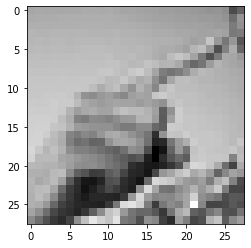

In [ ]:
img = to_image(train.iloc[1])
plt.imshow(img, cmap = 'gray')
plt.show()

In [ ]:
# The labels are coded in numbers. 
# Create a mapping to get the letters corresponding to the numbers
alphab = 'abcdefghijklmnopqrstuvwxyz'
mapping_letter = {}

for i,l in enumerate(alphab):
    mapping_letter[l] = i
mapping_letter = {v:k for k,v in mapping_letter.items()}

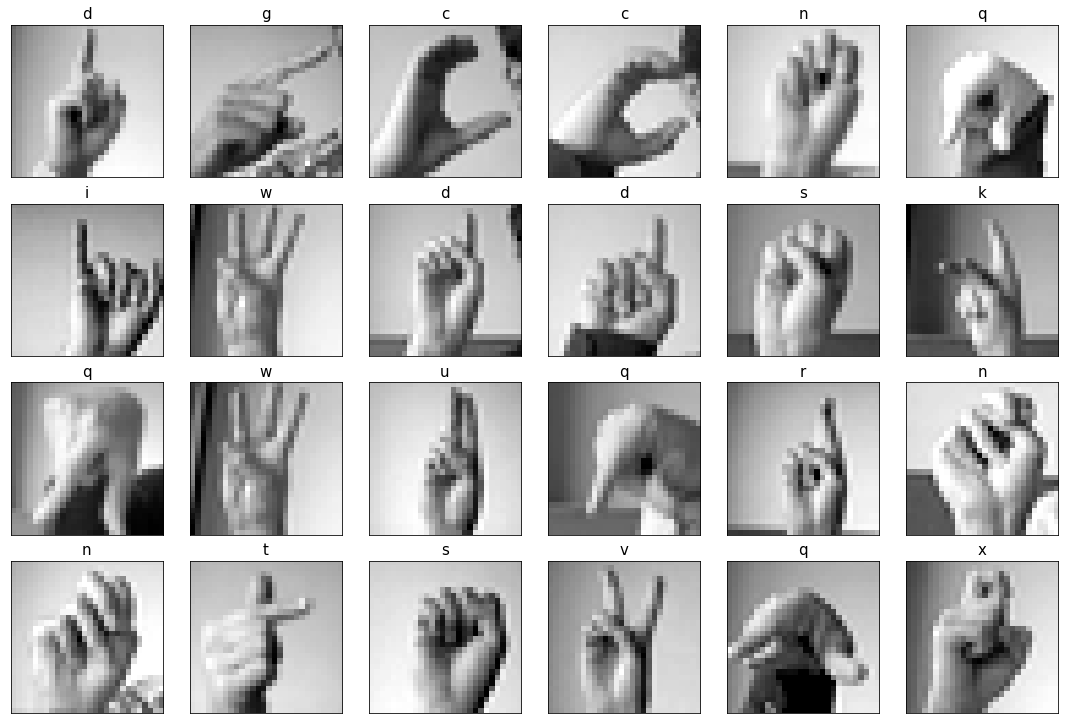

In [ ]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = to_image(train.iloc[i])
    ax.imshow(img, cmap = 'gray')
    title = mapping_letter[train.label[i]]
    ax.set_title(title, fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

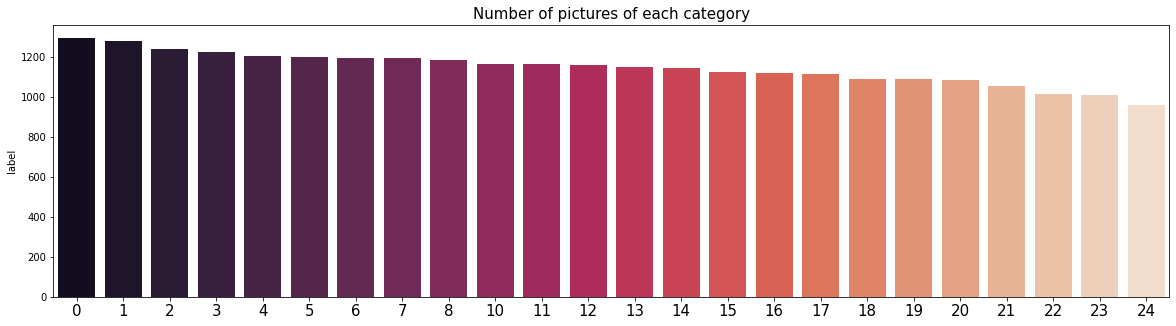

In [ ]:
# Display the number of pictures of each letter
vc = train['label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(fontsize = 15)
plt.show()

In [ ]:
train_df_original = train.copy()

# Split into training, test and validation sets
val_index = int(train.shape[0]*0.1)

train_df = train_df_original.iloc[val_index:]
val_df = train_df_original.iloc[:val_index]

y_train = train['label']
y_val = val_df['label']
y_test = test['label']

# Reshape the traing and test set to use them with a generator
X_train = train_df.drop('label',axis = 1).values.reshape(train_df.shape[0], 28, 28, 1)
X_val = val_df.drop('label',axis = 1).values.reshape(val_df.shape[0], 28, 28, 1)
X_test = test.drop('label',axis = 1).values.reshape(test.shape[0], 28, 28, 1)

In [ ]:
# Data augmentation
generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                            rotation_range=10,
                                                            zoom_range=0.10,
                                                            width_shift_range=0.1,
                                                            height_shift_range=0.1,
                                                            shear_range=0.1,
                                                            horizontal_flip=False,
                                                            fill_mode="nearest")

X_train_flow = generator.flow(x_train, y_train, batch_size=32)
x_val_flow = generator.flow(X_val, y_val, batch_size=32)
# X_test_flow = generator.flow(X_test, y_test)

In [ ]:
model = Sequential([Conv2D(filters=32,  kernel_size=(3,3), activation="relu", input_shape=(28,28,1)),
                    MaxPool2D(2,2, padding='same'),
                    
                    Conv2D(filters=128,  kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),
                    
                    Conv2D(filters=512, kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),
                    
                    Flatten(),
                    
                    Dense(units=1024, activation="relu"),                 
                    Dense(units=256, activation="relu"),
                    Dropout(0.5),
                    Dense(units=25, activation="softmax")
])

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 512)         590336    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 512)        0

In [36]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

history = model.fit(X_train_flow, 
                    validation_data=x_val_flow, 
                    epochs=100,
                    callbacks=[
                            tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=5,
                            restore_best_weights=True), 
                        
                            learning_rate_reduction
                    ])

Epoch 1/100
858/858 [==============================] - 110s 129ms/step - loss: 0.0998 - accuracy: 0.9680 - val_loss: 0.0453 - val_accuracy: 0.9872 - lr: 0.0010
Epoch 2/100
858/858 [==============================] - 110s 128ms/step - loss: 0.0613 - accuracy: 0.9813 - val_loss: 0.0259 - val_accuracy: 0.9905 - lr: 0.0010
Epoch 3/100
858/858 [==============================] - 110s 128ms/step - loss: 0.0528 - accuracy: 0.9838 - val_loss: 0.0145 - val_accuracy: 0.9949 - lr: 0.0010
Epoch 4/100
858/858 [==============================] - 109s 128ms/step - loss: 0.0399 - accuracy: 0.9879 - val_loss: 0.0220 - val_accuracy: 0.9945 - lr: 0.0010
Epoch 5/100
858/858 [==============================] - ETA: 0s - loss: 0.0426 - accuracy: 0.9883
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
858/858 [==============================] - 129s 150ms/step - loss: 0.0426 - accuracy: 0.9883 - val_loss: 0.0234 - val_accuracy: 0.9920 - lr: 0.0010
Epoch 6/100
858/858 [==============

In [38]:
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
# Predict the label of the test_images
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Get the accuracy score
acc = accuracy_score(y_test,pred)

# Display the results
printmd(f'## {acc*100:.2f}% accuracy on the test set')

## 99.96% accuracy on the test set

In [39]:
# Map the numbers into letters
y_test_letters = [mapping_letter[x] for x in y_test]
pred_letters = [mapping_letter[x] for x in pred]

In [40]:
print(classification_report(y_test_letters,pred_letters))

              precision    recall  f1-score   support

           a       1.00      1.00      1.00       331
           b       1.00      0.99      1.00       432
           c       1.00      1.00      1.00       310
           d       1.00      1.00      1.00       245
           e       1.00      1.00      1.00       498
           f       1.00      1.00      1.00       247
           g       1.00      1.00      1.00       348
           h       1.00      1.00      1.00       436
           i       1.00      1.00      1.00       288
           k       1.00      1.00      1.00       331
           l       1.00      1.00      1.00       209
           m       1.00      1.00      1.00       394
           n       1.00      1.00      1.00       291
           o       1.00      1.00      1.00       246
           p       0.99      1.00      1.00       347
           q       1.00      1.00      1.00       164
           r       1.00      1.00      1.00       144
           s       1.00    

In [41]:
from pandas.core.missing import interpolate_2d_with_fill
from pandas.core import frame
import cv2
cap = cv2.VideoCapture(0)
letter = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
while(True):
  ret,frame=cap.read()
  frame=cv2.flip(frame,1)
  dadada=model.predict_classes(np.expand_dims(np.expand_dims(resized, axis=2), axis=0))[0]
  cv2.putText(frame,letter[dadada],(200,200),cv2.FONT_HERSHEY_SIMPLEX,3,(0,0,122),3)
  cv2.imshow('frame', frame)
  if(cv2.waitKey(1) & 0xFF==ord('q')):
    break
cap.release()
cv2.destroyAllWindows()

AttributeError: ignored

In [47]:
# import the opencv library
import cv2
from google.colab.patches import cv2_imshow



# define a video capture object
vid = cv2.VideoCapture(0)

while(True):
	
	# Capture the video frame
	# by frame
	ret, frame = vid.read()

	# Display the resulting frame
	cv2_imshow(frame)
	
	# the 'q' button is set as the
	# quitting button you may use any
	# desired button of your choice
	if cv2.waitKey(1) & 0xFF == ord('q'):
		break

# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()


AttributeError: ignored

In [49]:
    from pandas.core.missing import interpolate_2d_with_fill
    import cv2
    from google.colab.patches import cv2_imshow


    cap = cv2.VideoCapture(0)
    letter = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    
    
    # define a video capture object
    vid = cv2.VideoCapture(0)
    
    while(True):
    
        ret, frame = vid.read()
        frame=cv2.flip(frame,1)
        roi=frame[0:300,0:300]
        roi.sort()
        cv2.rectangle(frame,(0,0),(300,300),(0,255,0),2)
        resized =cv2.resize(roi,(28,28), interpolation = cv2.INTER_AREA)
        resized = cv2.cvtColor(resized,cv2.COLOR_BGR2GRAY)
        dadada=model.predict_classes(np.expand_dims(np.expand_dims(resized, axis=2), axis=0))[0]
        cv2.putText(frame,letter[dadada],(200,200),cv2.FONT_HERSHEY_SIMPLEX,3,(0,0,122),3)
        cv2_imshow('frame', frame)
        cv2_imshow('mask', resized)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # After the loop release the cap object
    vid.release()
    # Destroy all the windows
    cv2.destroyAllWindows()

TypeError: ignored

In [50]:
import numpy as np
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [51]:
background = None
accumulated_weight = 0.5
ROI_top = 100
ROI_bottom = 300
ROI_right = 150
ROI_left = 350

In [52]:
def cal_accum_avg(frame, accumulated_weight):
    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None
    cv2.accumulateWeighted(frame, background, accumulated_weight)

In [56]:
def segment_hand(frame, threshold=25):
    global background
    diff = cv2.absdiff(background.astype("uint8"), frame)
    _ , thresholded = cv2.threshold(diff, threshold, 255,cv2.THRESH_BINARY)
    image, contours, hierarchy = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    else:
      return (thresholded, hand_segment_max_cont)


In [60]:
cam = cv2.VideoCapture(0)
num_frames =0
while True:
    ret, frame = cam.read()
    # flipping the frame to prevent inverted image of captured frame...
    
    frame = cv2.flip(frame, 1)
  
   
        
        # Checking if we are able to detect the hand...
        if hand is not None:
            
            thresholded, hand_segment = hand
            # Drawing contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right,
      ROI_top)], -1, (255, 0, 0),1)
            
            cv2.imshow("Thesholded Hand Image", thresholded)
            
            thresholded = cv2.resize(thresholded, (64, 64))
            thresholded = cv2.cvtColor(thresholded,
 cv2.COLOR_GRAY2RGB)
            thresholded = np.reshape(thresholded,
(1,thresholded.shape[0],thresholded.shape[1],3))
            
            pred = model.predict(thresholded)
            cv2.putText(frame_copy, word_dict[np.argmax(pred)],
(170, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
    # Draw ROI on frame_copy
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right,
    ROI_bottom), (255,128,0), 3)
    # incrementing the number of frames for tracking
    num_frames += 1
    # Display the frame with segmented hand
    cv2.putText(frame_copy, "DataFlair hand sign recognition_ _ _",
    (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    cv2.imshow("Sign Detection", frame_copy)
    # Close windows with Esc
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
# Release the camera and destroy all the windows
cam.release()
cv2.destroyAllWindows()

IndentationError: ignored